In [2]:
import math
from random import seed
import os
import pandas as pd
from itertools import combinations
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import xlsxwriter

In [3]:
#set seed for reproducibility
np.random.seed(42)

In [2]:
#Read all SNP files from FUMA analysis

# Directory path
directory_path = 'FUMA_dowloads_all_tissue/SNPs'

snp_df_list = []
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t')

        # Choose columns of interest
        df['disorder'] = disorder_name
        df = df[['uniqID','rsID','gwasP','disorder']]
        df = df.dropna()
        df.reset_index(inplace=True, drop=True)
        # Append the DataFrame to the list
        snp_df_list.append(df)

In [6]:
#Read all eQTL files from FUMA analysis

# Directory path
directory_path = 'FUMA_dowloads_all_tissue/eQTL'


gene_df_list = []
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t', low_memory=False)

        # Choose columns of interest
        df['disorder'] = disorder_name
        df = df[['uniqID','gene','symbol','tissue','disorder','p']]
        df = df.dropna()
        df.reset_index(inplace=True, drop=True)
        # Append the DataFrame to the list
        gene_df_list.append(df)

In [7]:
gene_df_list[0]

,uniqID,gene,symbol,tissue,disorder,p
0,1:26482556:C:T,ENSG00000142684,ZNF593,Nom_Alonso_Pancreatic_islets,ADHD,4.577000e-10
1,1:26485291:C:T,ENSG00000142684,ZNF593,Nom_Alonso_Pancreatic_islets,ADHD,1.930000e-08
2,1:26490848:C:T,ENSG00000142684,ZNF593,Nom_Alonso_Pancreatic_islets,ADHD,7.251000e-10
3,1:43760070:C:T,ENSG00000159479,MED8,Nom_Alonso_Pancreatic_islets,ADHD,8.319000e-05
4,1:43760070:C:T,ENSG00000178922,HYI,Nom_Alonso_Pancreatic_islets,ADHD,1.170000e-05
...,...,...,...,...,...,...
998532,11:807149:A:G,ENSG00000255284,AP006621.5,Vagina,ADHD,9.133400e-08
998533,11:812188:A:G,ENSG00000255284,AP006621.5,Vagina,ADHD,7.322480e-07
998534,11:813524:C:T,ENSG00000255284,AP006621.5,Vagina,ADHD,7.530170e-07
998535,11:815323:G:T,ENSG00000255284,AP006621.5,Vagina,ADHD,7.911630e-07


In [ ]:

""" # Split data into psychiatric and other
valid_strings = ['ADHD','ANOREXIA','ANXIETY','ASD','AUD','BPD','CUD','HOARDING','MDD','OCD','PTSD','SZC','TOURETTES']

psych_snp_dfs = []
other_snp_dfs = []
psych_genes_dfs = []
other_genes_dfs = []

for df in snp_df_list:
    # Check if any valid string is present in the 'disorder' column
    if any(df['disorder'].str.contains(valid_string).any() for valid_string in valid_strings):
        # If at least one valid string is present, append the dataframe to psych_snps_dfs
        psych_snp_dfs.append(df)
    else:
        # If no valid string is present, append the dataframe to other_snp_dfs
        other_snp_dfs.append(df)


for df in gene_df_list:
    # Check if any valid string is present in the 'disorder' column
    if any(df['disorder'].str.contains(valid_string).any() for valid_string in valid_strings):
        # If at least one valid string is present, append the dataframe to psych_genes_dfs
        psych_genes_dfs.append(df)
    else:
        # If no valid string is present, append the dataframe to other_genes_dfs
        other_genes_dfs.append(df) """

In [72]:
# extract all genes from each disorder and save to file
output_folder = 'genes_with_pval'
os.makedirs(output_folder, exist_ok=True)

# Iterate through each dataframe
for df in gene_df_list:
    # Extract disorder name
    disorder_name = df['disorder'].iloc[0] 
    
    # Extract unique symbols and save to txt file
    unique_symbols = df['gene'].drop_duplicates().tolist()
    output_file = os.path.join(output_folder, f"{disorder_name}.txt")
    with open(output_file, 'w') as f:
        for symbol in unique_symbols:
            f.write(f"{symbol}\n")

In [ ]:
concat_snps = pd.concat(snp_df_list)
snpID = concat_snps[['uniqID','rsID']]
concat_genes = pd.concat(gene_df_list)
merged_df = pd.merge(concat_genes,snpID,on=['uniqID'], how='left')

In [ ]:
merged_df.head(50)

In [4]:
def make_binary_matrix(df_list, column1,column2):
    concatenated= pd.concat(df_list)
    df = concatenated[[column1, column2]]
    
    return df.pivot_table(index=column1, columns=column2, aggfunc=lambda x: 1, fill_value=0)

In [5]:
all_snps_binary = make_binary_matrix(snp_df_list, 'rsID', 'disorder')
all_genes_binary = make_binary_matrix(gene_df_list,'symbol', 'disorder')
""" psych_snps_binary = make_binary_matrix(psych_snp_dfs,'rsID', 'disorder')
genes_psych_binary = make_binary_matrix(psych_genes_dfs,'symbol', 'disorder') """

" psych_snps_binary = make_binary_matrix(psych_snp_dfs,'rsID', 'disorder')\ngenes_psych_binary = make_binary_matrix(psych_genes_dfs,'symbol', 'disorder') "

In [6]:
print(all_snps_binary.sum(axis=0))


disorder
ADHD                 7018
ANOREXIA             2562
ANXIETY                84
ARTHRITIS           13819
ASD                  4006
AUD                  5984
BILIARYCHIRROSIS     9791
BPD                 27077
CHRONICPAIN          5669
CUD                   719
ENDOMETRIOSIS        1394
EPILEPSY              462
FATIGUE               193
GDM                  1027
GH                    403
GOUT                  269
HOARDING               79
IBD                    94
IBS                   432
LUPUS               17546
MDD                 15332
MIGRAINE             2583
MS                   1302
MYASTHENIAGRAVIS      129
OCD                   130
PARKINSONS           5508
PCOS                    1
PREECLAMPSIA         1792
PTSD                  186
SJOGRENS              621
SZC                 41691
THYROIDDISEASE          6
TOURETTES             292
dtype: int64


In [7]:
print(all_genes_binary.sum(axis=0))
#all_genes_binary.to_csv('all_genes_binary.csv')

disorder
ADHD                1135
ANOREXIA             474
ANXIETY               43
ARTHRITIS           2660
ASD                  308
AUD                  678
BILIARYCHIRROSIS    2434
BPD                 2440
CHRONICPAIN          435
CUD                  308
ENDOMETRIOSIS        104
EPILEPSY              28
FATIGUE               73
GDM                   81
GH                    38
GOUT                 325
HOARDING              42
IBD                  101
IBS                   23
LUPUS               1888
MDD                 1485
MIGRAINE             566
MS                  1579
MYASTHENIAGRAVIS      47
OCD                   44
PARKINSONS           802
PREECLAMPSIA         656
PTSD                 128
SJOGRENS              71
SZC                 4149
THYROIDDISEASE        10
TOURETTES            164
dtype: int64


In [8]:
def find_max_row(binary_df):
    row_sums = binary_df.sum(axis=1)

    # Find the maximum sum
    max_row_sum = row_sums.max()
    
    print("Maximum number of 1's in the row:", max_row_sum)
    return max_row_sum

In [9]:
max_combo_snps = find_max_row(all_snps_binary)
max_combo_genes = find_max_row(all_genes_binary)

Maximum number of 1's in the row: 6
Maximum number of 1's in the row: 13


In [10]:
def count_combos(binary_df, max_combo):

    num_iterations = 10

    # Get all possible combinations of disorders
    all_combinations = []
    for r in range(2,max_combo):
        all_combinations.extend(list(combinations(binary_df.columns, r)))

    # Create an empty DataFrame with rows as each combination and columns for storing counts in each iteration
    counts_df = pd.DataFrame(index=all_combinations, columns=range(1,num_iterations+1))

    # Perform the iterations
    for i in range(1,num_iterations+1):
        # Permute the columns independently
        permuted_df = binary_df.apply(np.random.permutation, axis=0)

        iteration_counts = []

        # Count occurrences for each combination in this iteration
        for combo in all_combinations:
            # Check if all disorders in the combination are present in each row
            count = (permuted_df[list(combo)] == 1).all(axis=1).sum()
            iteration_counts.append(count)

        # Store the counts for this iteration in the dataFrame
        counts_df[i] = iteration_counts

    return counts_df

In [11]:
def count_combos_real_data(binary_df, max_combo):
#Count all occurrences for each combination and store in a new dataframe

    # Get all possible combinations of disorders 
    all_combinations = []
    for r in range(2,max_combo):
        all_combinations.extend(list(combinations(binary_df.columns, r)))
        
    #Create empty dataframe to store the count
    count_df = pd.DataFrame(index=all_combinations, columns=['Count'])

    iteration_counts = []

    # Count occurrences for each combination in this iteration 
    for combo in all_combinations:
        # Check if all disorders in the combination are present in each row
        count = (binary_df[list(combo)] == 1).all(axis=1).sum()
        iteration_counts.append(count)

    # Store the counts for this iteration in the counts_df DataFrame
    count_df['Count'] = iteration_counts
    
    return count_df


In [13]:

#psych_snps_randomized = count_combos(psych_snps_binary)
#all_snps_randomized = count_combos(all_snps_binary)
#psych_genes_randomized = count_combos(genes_psych_binary)
all_genes_combo_count = count_combos_real_data(all_genes_binary, 6)
all_genes_randomized = count_combos(all_genes_binary, 6)

#psych_snps_combo_count = count_combos_real_data(psych_snps_binary)
#all_snps_combo_count = count_combos_real_data(all_snps_binary)
#psych_genes_combo_count = count_combos_real_data(genes_psych_binary)



In [55]:
#function to calculate z-scores and sort the result

def calculate_z_score(df, df_rand, threshold, count):
    
    #calculate mean and standard deviation
    means = round(df_rand.mean(axis=1),2)
    std = round(df_rand.std(axis=1),2)

    df_rand['mean'] = means
    df_rand['std'] = std
    df_rand['actual'] = df['Count']
    
    new_df = df_rand[['actual', 'mean', 'std']]
    
    #Make copies to avoid warnings
    new_df_copy = new_df.copy()
    
    
    # Calculate Z-scores 
    new_df_copy['z-score'] = round((new_df_copy['actual'] - new_df_copy['mean']) / new_df_copy['std'],2)
    
    
    sorted_df = new_df_copy.sort_values(by='z-score', ascending=False)
    
    # Replace infinite values in the "z-score" column with NaN
    sorted_df['z-score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows with NaN values in the "z-score" column
    sorted_df.dropna(subset=['z-score'], how='any', inplace=True)

    return sorted_df[(sorted_df['z-score'] >= threshold) & (sorted_df['actual'] >= count)]    

In [60]:
#z_psych_snps2 = calculate_z_score(psych_snps_combo_count, psych_snps_randomized,2,5)
#z_all_snps2 = calculate_z_score(all_snps_combo_count, all_snps_randomized,2,5)
#z_psych_genes2 = calculate_z_score(psych_genes_combo_count, psych_genes_randomized,2,5)
z_all_genes2 = calculate_z_score(all_genes_combo_count, all_genes_randomized,2,5)

#z_psych_snps3 = calculate_z_score(psych_snps_combo_count, psych_snps_randomized,3,5)
#z_all_snps3 = calculate_z_score(all_snps_combo_count, all_snps_randomized,3,5)
#z_psych_genes3 = calculate_z_score(psych_genes_combo_count, psych_genes_randomized,3,5)
z_all_genes3 = calculate_z_score(all_genes_combo_count, all_genes_randomized,3,5)

In [61]:
z_all_genes2.head()

,actual,mean,std,z-score
"(LUPUS, PREECLAMPSIA)",572,165.41,122.87,3.31
"(ARTHRITIS, BPD, LUPUS, SZC)",293,80.68,64.18,3.31
"(ARTHRITIS, BILIARYCHIRROSIS, MDD, SZC)",223,62.23,48.72,3.30
"(BILIARYCHIRROSIS, BPD, LUPUS, SZC)",285,76.03,63.37,3.30
"(ARTHRITIS, BILIARYCHIRROSIS, MS, SZC)",295,72.38,67.53,3.30


In [59]:
z_all_genes2.to_csv('genes_zscore_2.csv')
z_all_genes3.to_csv('genes_zscore_3.csv')

In [62]:
print(len(z_all_genes2))
print(len(z_all_genes3))

3681
2838


In [63]:
z = {'No. of combinations with z-value >= 2':len(z_all_genes2),'No. of combinations with z-value >= 3':len(z_all_genes3)}
z_df = pd.DataFrame(data=z, index=['Genes'])

In [64]:
z_df

,No. of combinations with z-value >= 2,No. of combinations with z-value >= 3
Genes,3681,2838


In [ ]:
link = hierarchy.linkage(all_snps_binary.T, method='average', metric='hamming')
# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(link, labels=all_snps_binary.columns)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram SNPs')
plt.xticks(rotation=90)
plt.show()  

In [38]:
# select top 500 SNPs ranked by significance
top_snp_list = []
for df in snp_df_list:
    sorted = df.sort_values(by=['gwasP'])
    top_snps = sorted.iloc[:500]
    top_snps.reset_index(drop=True,inplace=True)
    top_snp_list.append(top_snps)

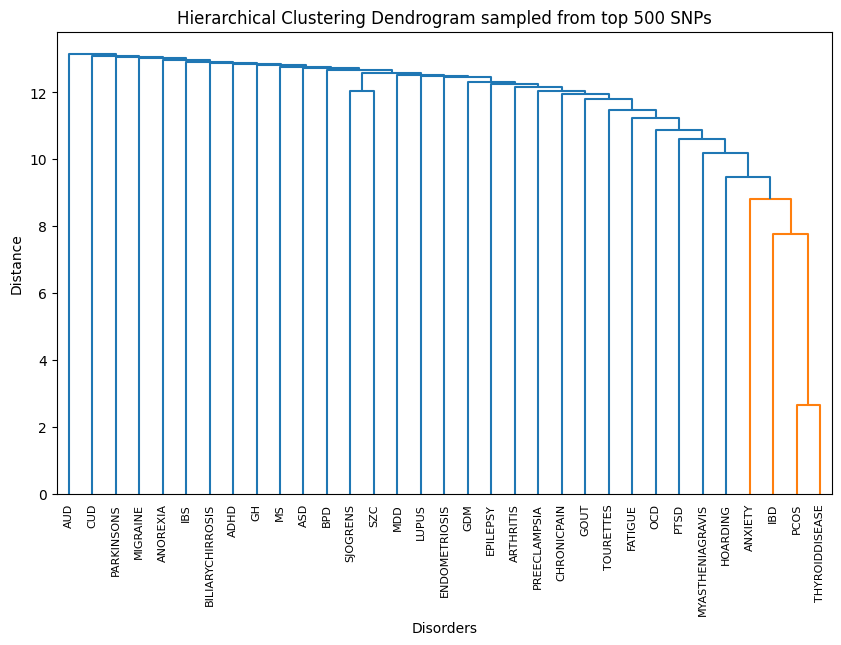

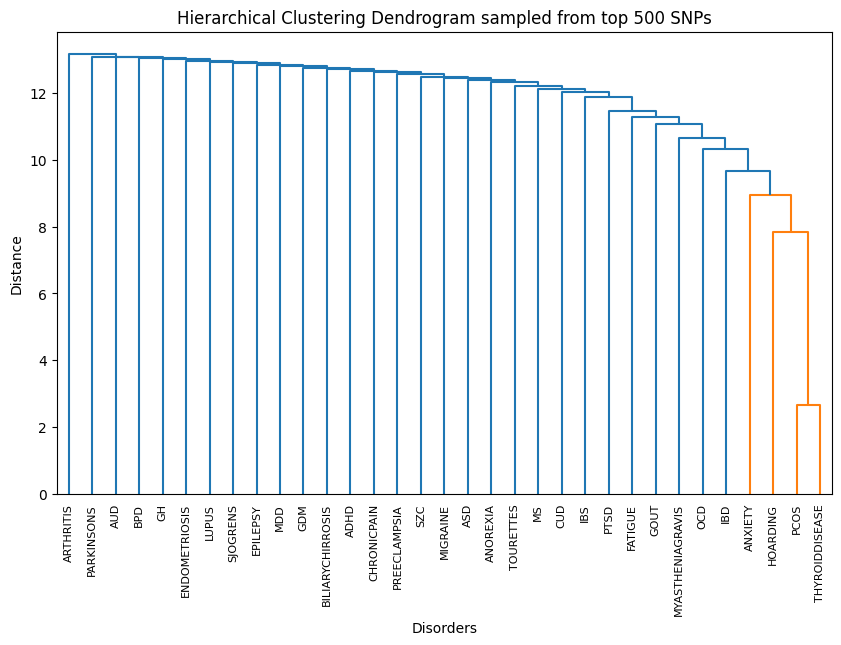

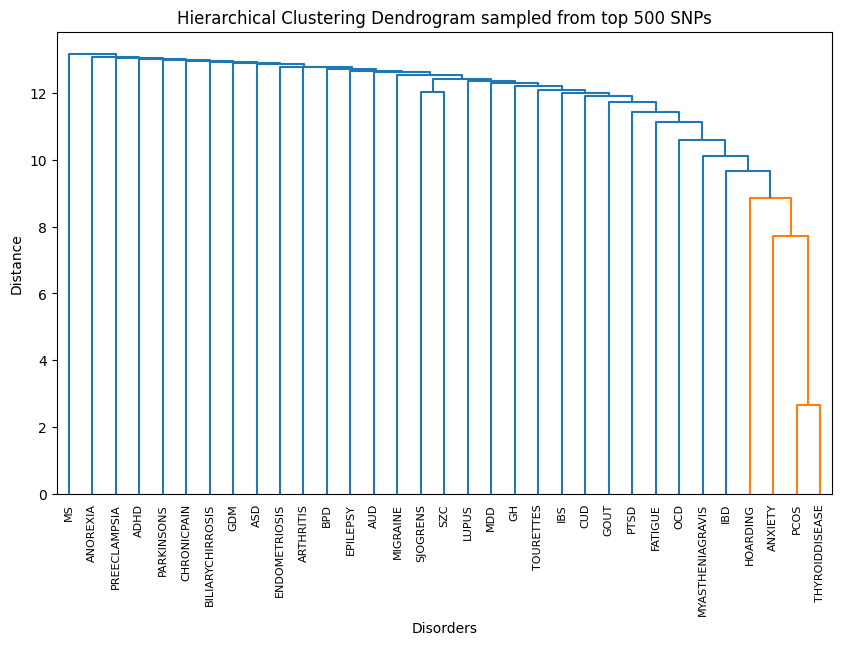

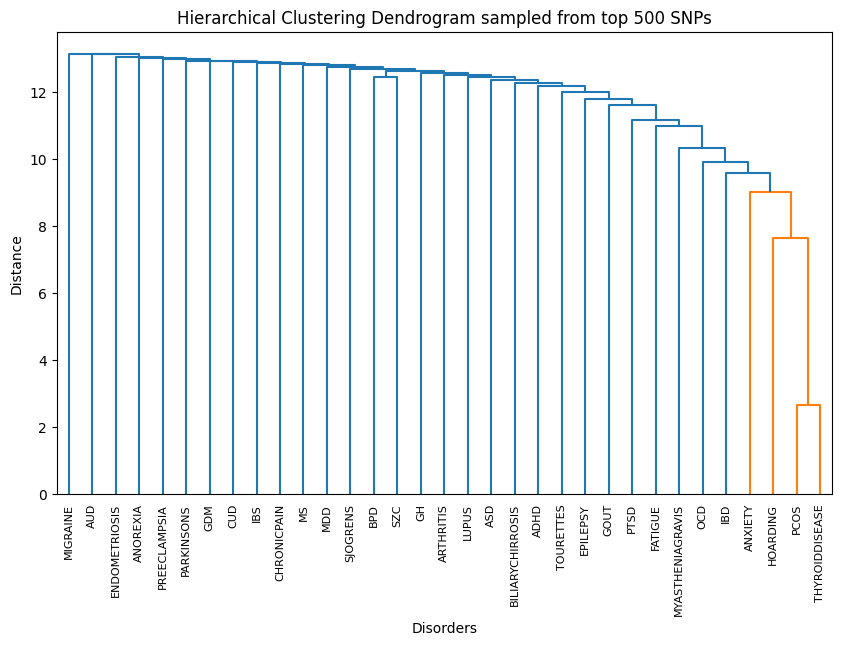

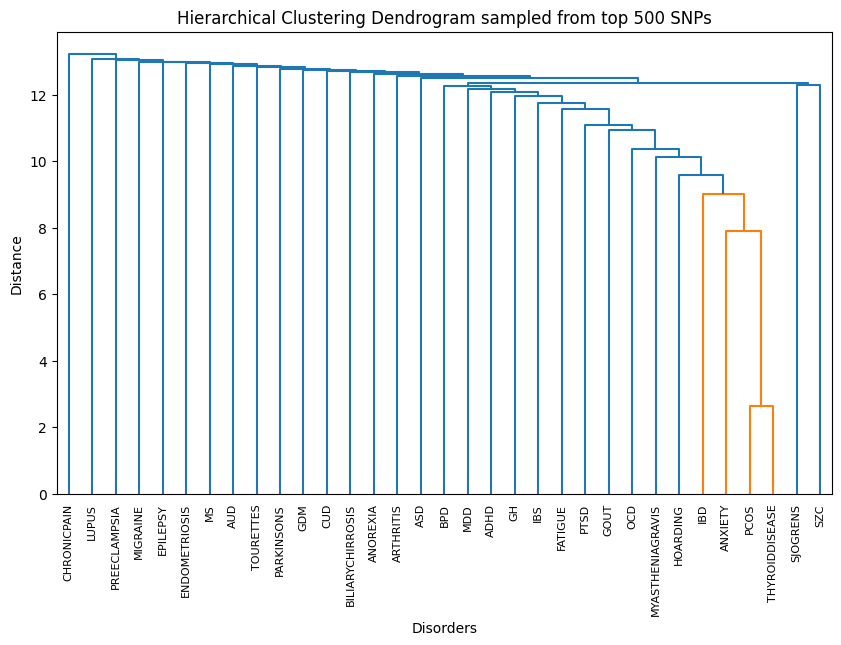

" # Compute the mean linkage matrix\nmean_linkage = np.mean(all_linkage, axis=0)\nprint(mean_linkage)\n# Plot the dendrogram for the mean linkage matrix\nplt.figure(figsize=(10, 6))\ndendrogram = hierarchy.dendrogram(mean_linkage)\nplt.xlabel('Disorders')\nplt.ylabel('Distance')\nplt.title('Consensus Hierarchical Clustering Dendrogram')\nplt.xticks(rotation=90)\nplt.show() "

In [69]:
#  randomly select a given number of SNPs

all_linkage = []

# Perform hierarchical clustering 10 times and store the linkage matrices
for _ in range(5):
    sampled_dfs = []
    for df in top_snp_list:
        sampled = df.sample(100, axis=0, replace=True)
        sampled.reset_index(inplace=True, drop=True)
        sampled_dfs.append(sampled)

    sampled_binary = make_binary_matrix(sampled_dfs, 'rsID', 'disorder')
    

    # Hierarchical clustering
    linkage_matrix = hierarchy.linkage(sampled_binary.T, method='average')
    all_linkage.append(linkage_matrix)

# Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, labels=sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram sampled from top 500 SNPs')
    plt.xticks(rotation=90)
    plt.show()  

""" # Compute the mean linkage matrix
mean_linkage = np.mean(all_linkage, axis=0)
print(mean_linkage)
# Plot the dendrogram for the mean linkage matrix
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Consensus Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.show() """

In [ ]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix, disorders_of_interest):
    overlaps = []
    overlapping_genes = set()

    for index, row in binary_matrix.iterrows():
        ones = {col for col, val in row.items() if val == 1 and col in disorders_of_interest}

        if ones and ones == set(disorders_of_interest):
            overlaps.append((index, ones))
            overlapping_genes.add(index)

    # Write overlapping genes to a file
    with open('genes_to_enrichR.txt', 'w') as file:
        for gene in overlapping_genes:
            file.write(gene + '\n')

    return overlaps, list(overlapping_genes) 


In [ ]:
dis_of_int = ['SZC','BPD']
overlapping_genes, gene_list = find_overlaps(all_genes_binary, dis_of_int)
#overlapping_snps = find_overlaps(all_snps_binary)

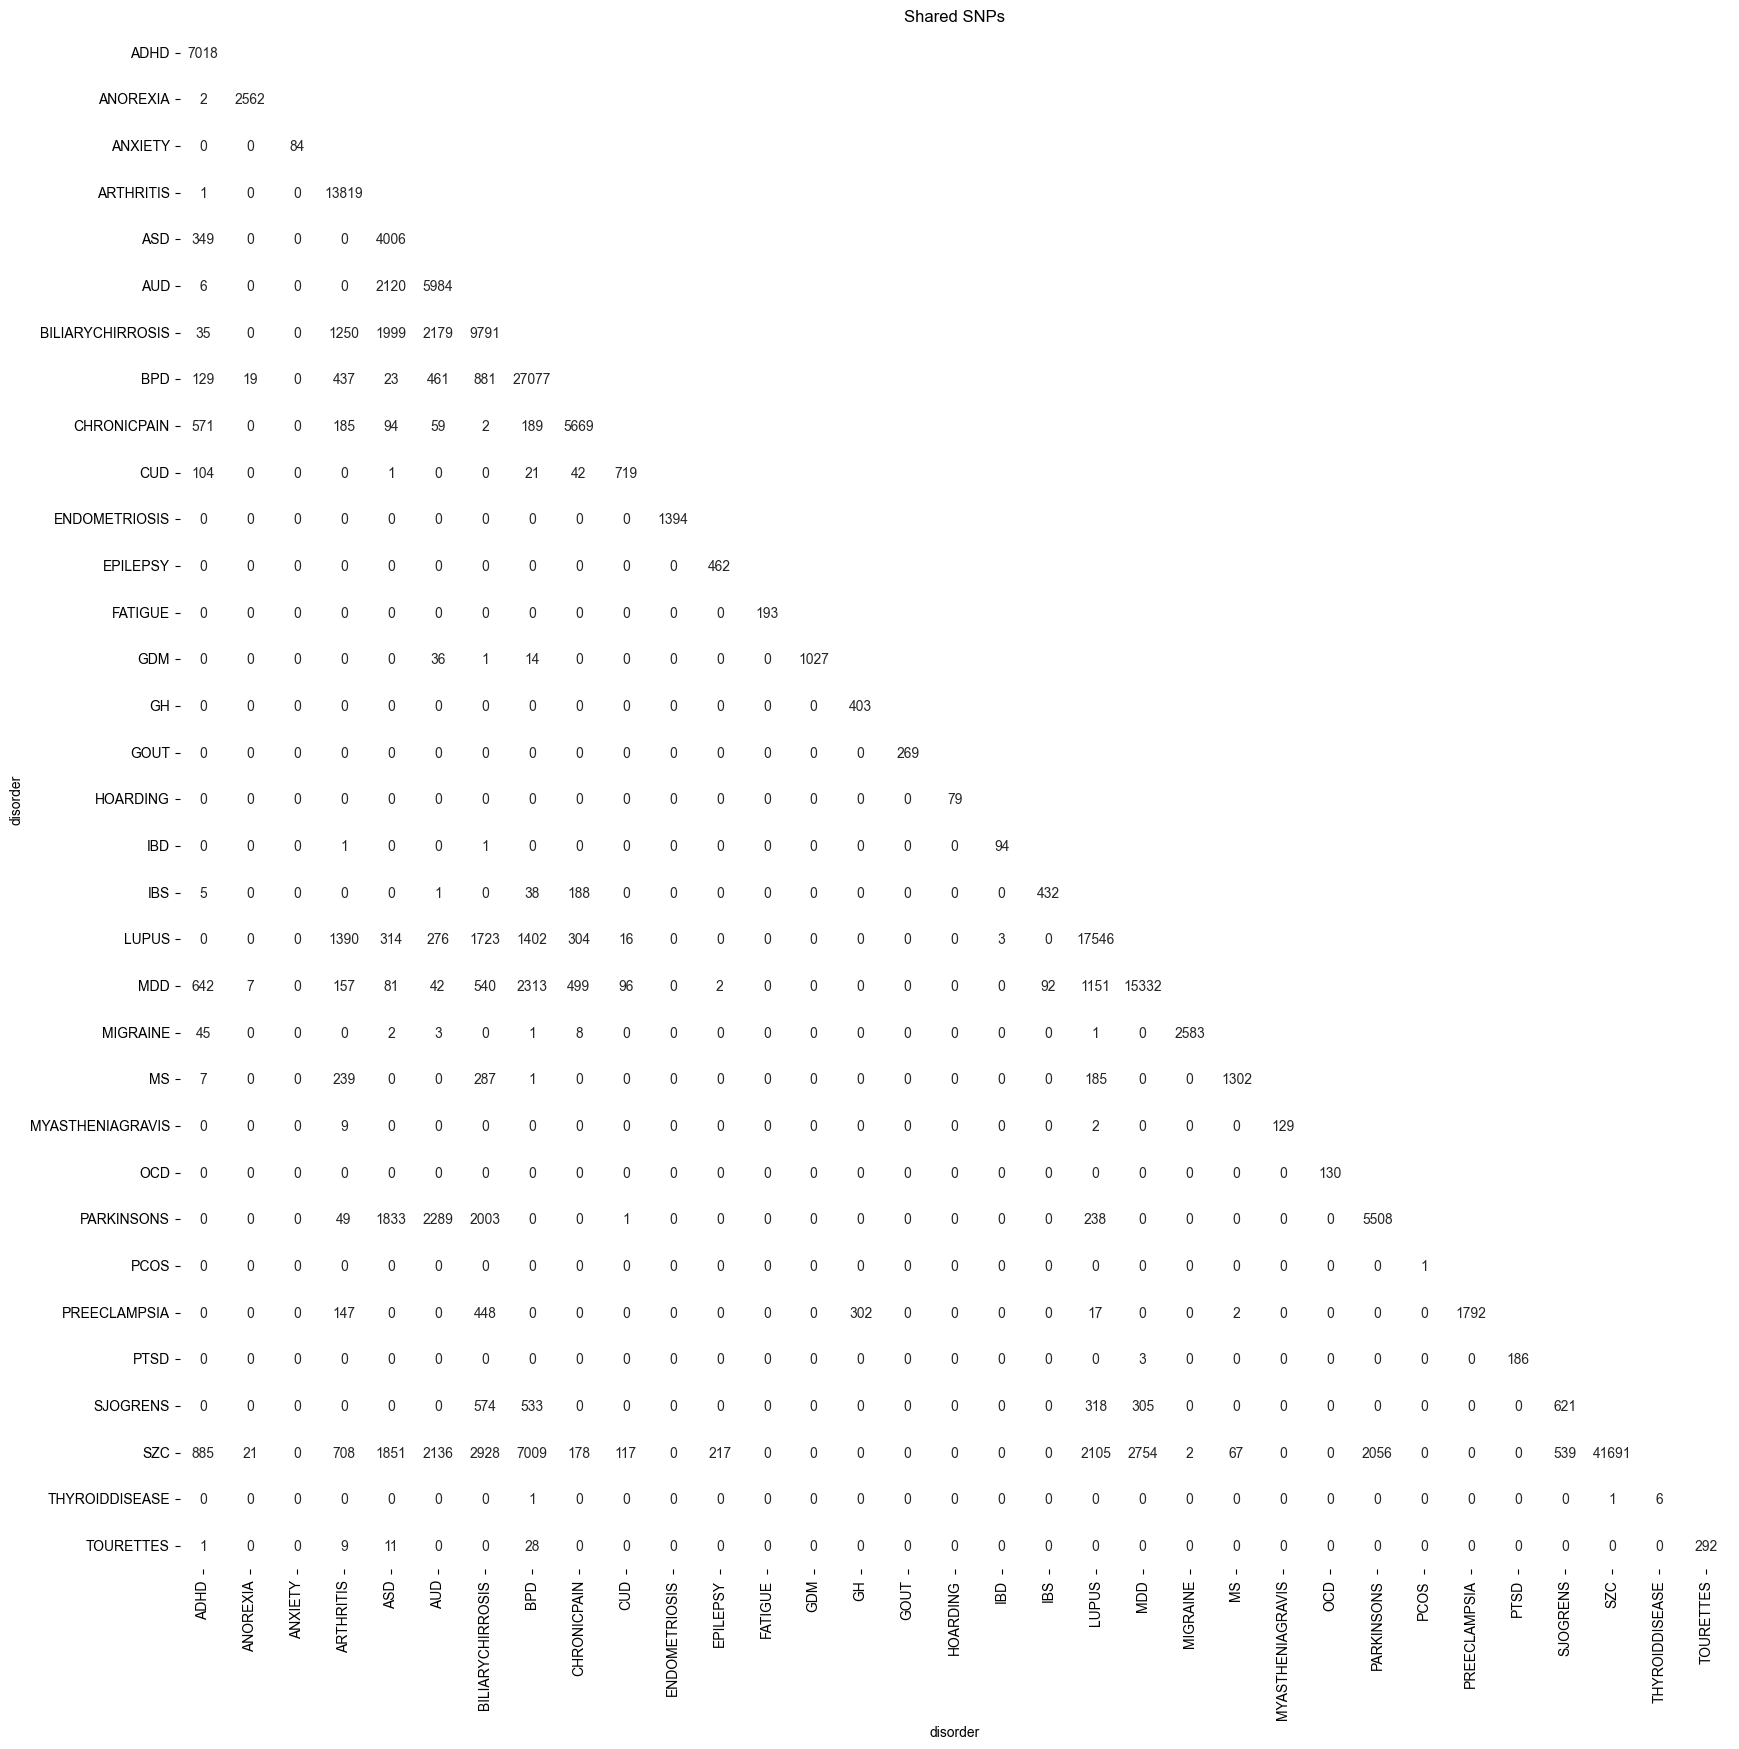

In [74]:
shared_snps = pd.DataFrame(index=all_snps_binary.columns, columns=all_snps_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_snps_binary.columns:
    for disorder2 in all_snps_binary.columns:
        count=sum(all_snps_binary[disorder1] & all_snps_binary[disorder2])
        shared_snps.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_snps_binary.columns:
    total_count = all_snps_binary[disorder].sum()
    shared_snps.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders_snps = shared_snps.columns.tolist()
disorder_matrix_snps = shared_snps.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_snps), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_snps[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_snps, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared SNPs')
    plt.show()

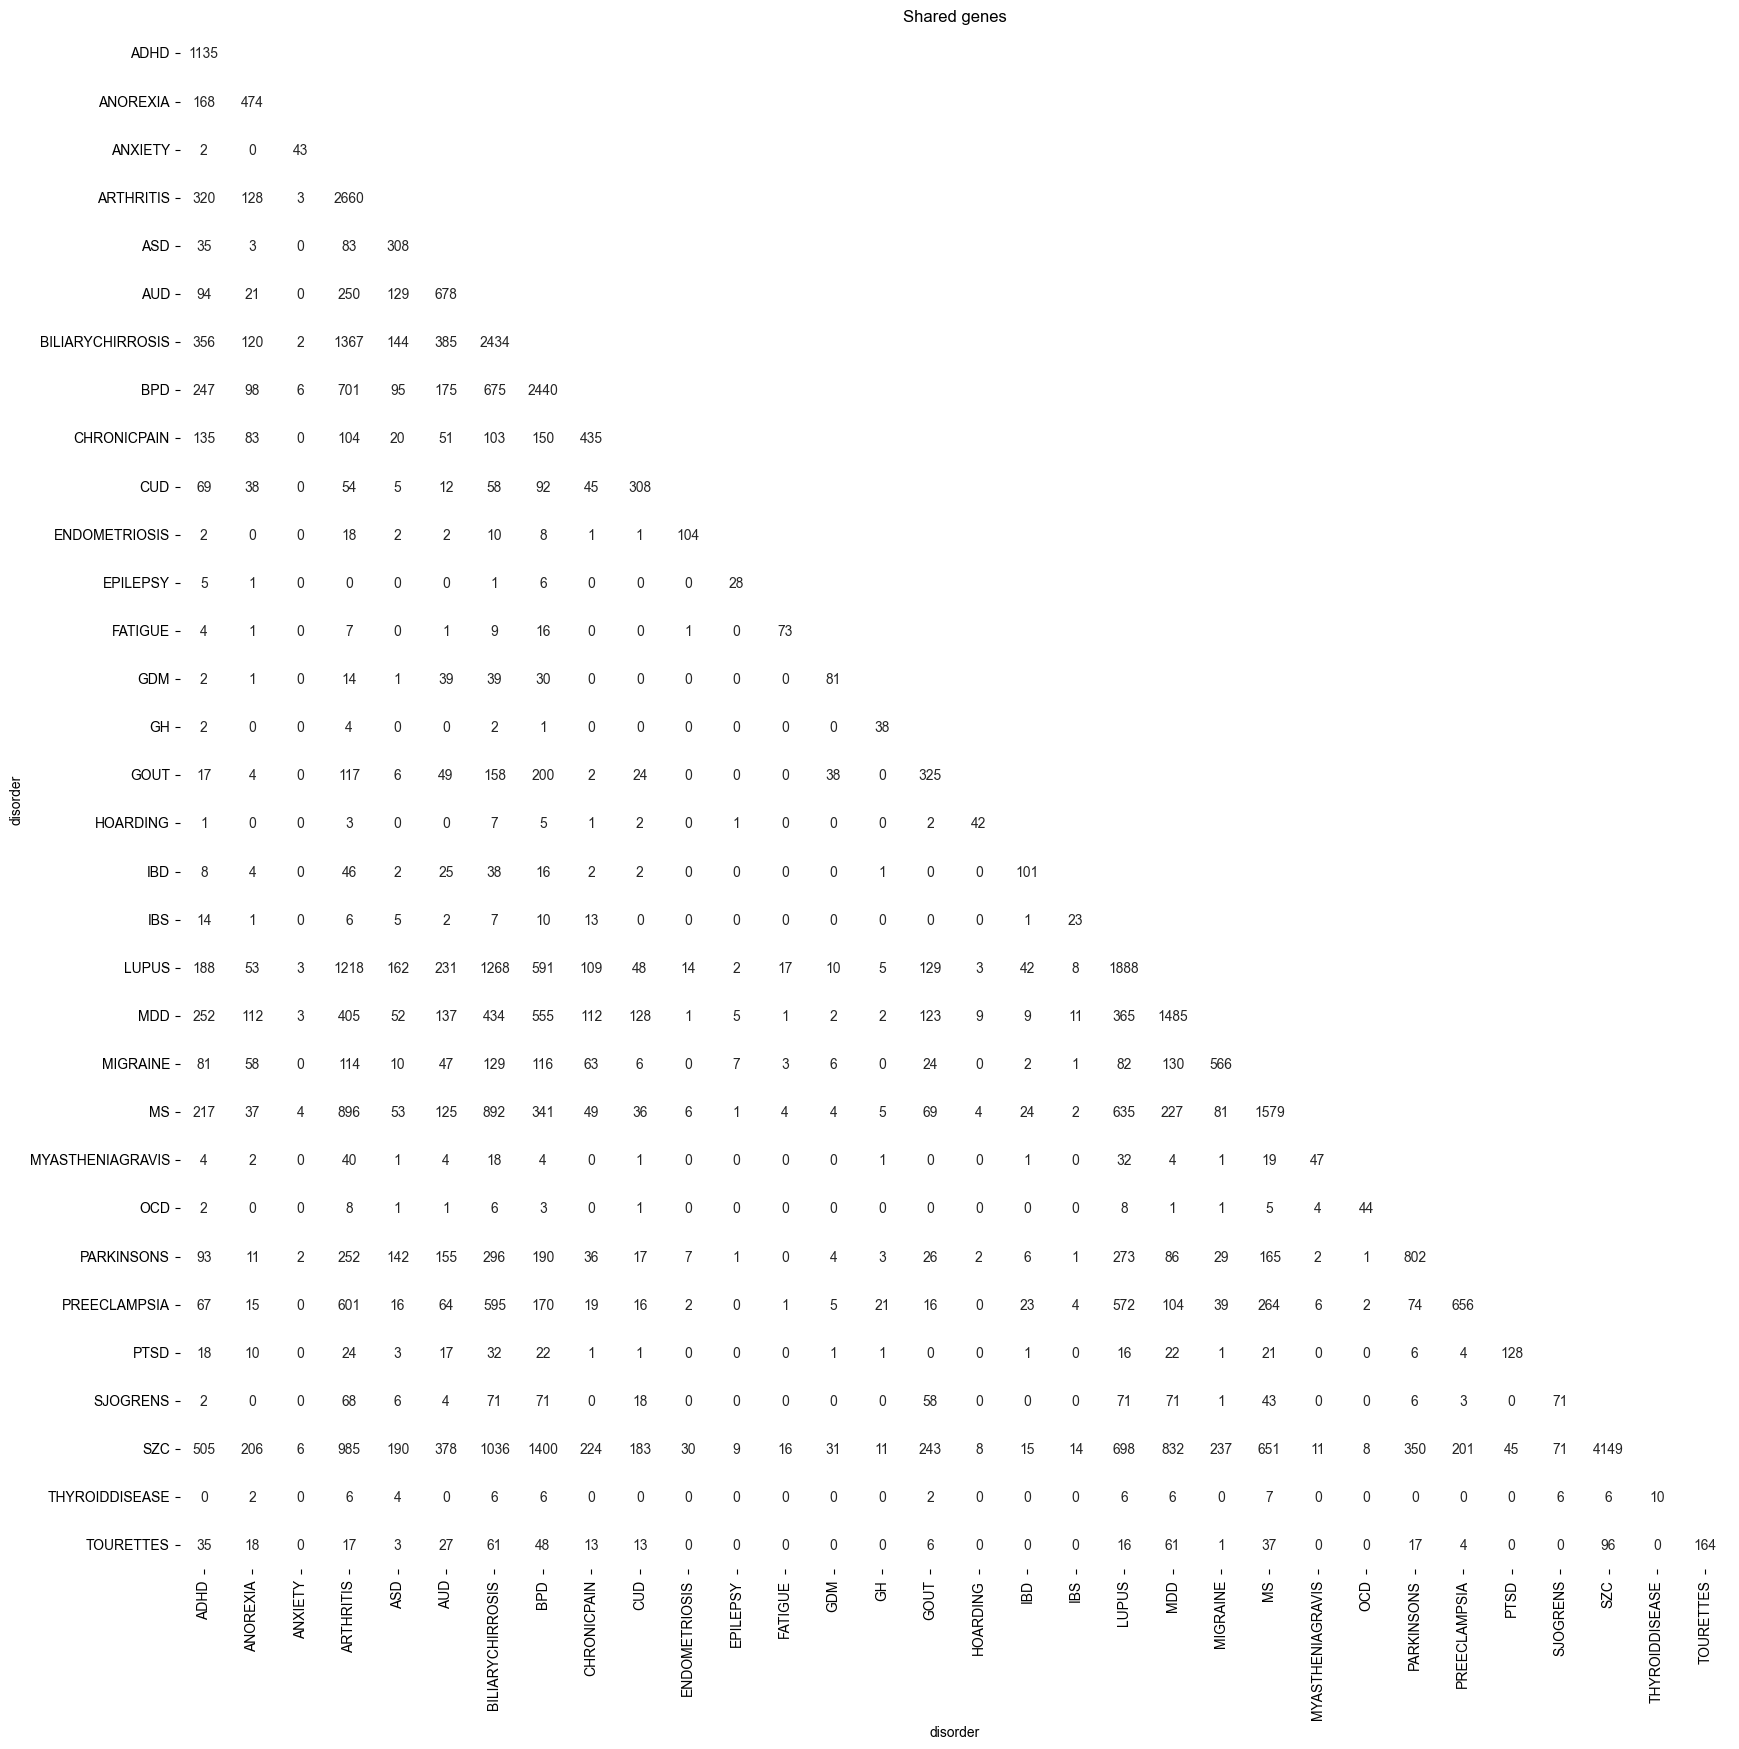

In [75]:
shared_genes = pd.DataFrame(index=all_genes_binary.columns, columns=all_genes_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_genes_binary.columns:
    for disorder2 in all_genes_binary.columns:
        count=sum(all_genes_binary[disorder1] & all_genes_binary[disorder2])
        shared_genes.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_genes_binary.columns:
    total_count = all_genes_binary[disorder].sum()
    shared_genes.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders = shared_genes.columns.tolist()
disorder_matrix = shared_genes.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_genes), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_genes[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20,20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_genes, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared genes')
    plt.show()

In [ ]:
""" #function to make binary matrix with randobly selected snps
def make_random_binary_matrix(number_i, list_of_snps, number_of_snps):
    random_binary_list = []
    for i in range(number_i):
        random = select_snps_randomly(list_of_snps, number_of_snps)
        concatenated_random = pd.concat(random)
    
        binary = concatenated_random.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
        random_binary_list.append(binary)
    return random_binary_list """


In [25]:

def hypergeometric_prob(matrix, disorder_list, M):

    matrix_shape= matrix.shape
    prob_matrix = np.zeros(matrix_shape)

    for i in range(1, matrix_shape[0]):
        for j in range(i):
            x =matrix[i,j]
            n = matrix[j,j]
            N = matrix[i, i]
            #print(M,n,x)
            
            prob = hypergeom.sf(x-1, M, n, N)
            
                
            prob_matrix[i,j] = prob

    return pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

   

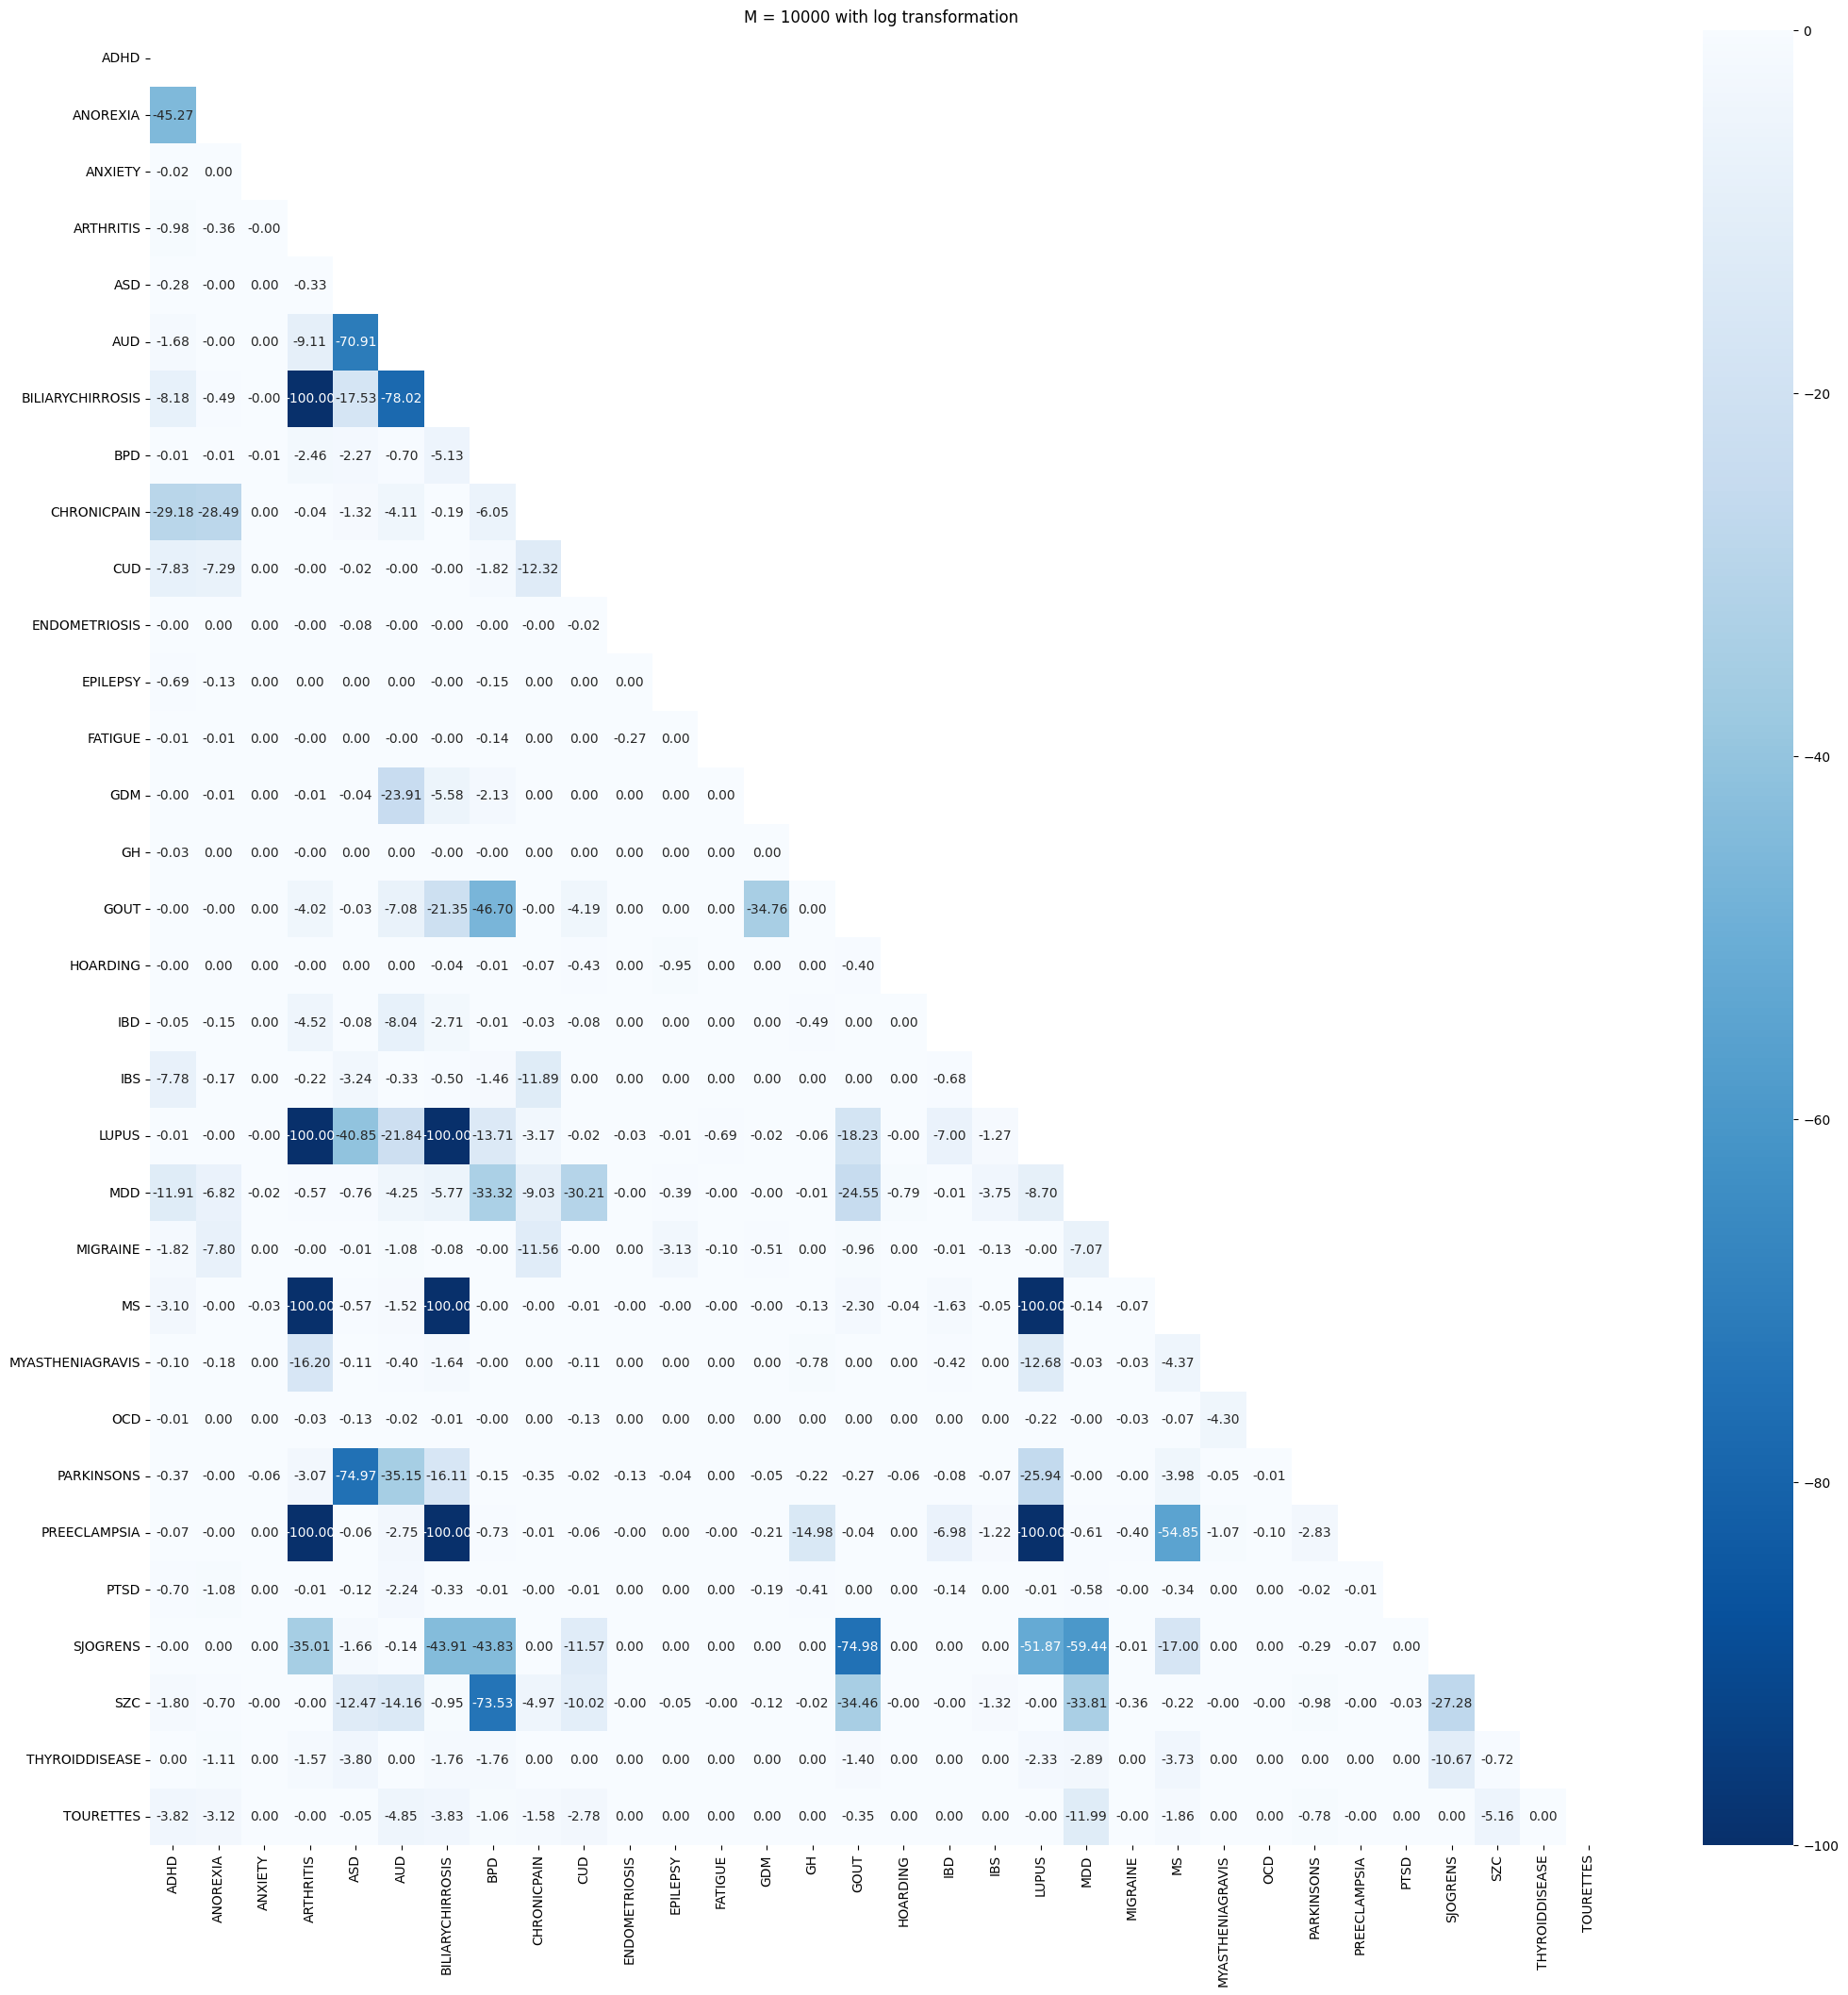

<Figure size 2500x2500 with 0 Axes>

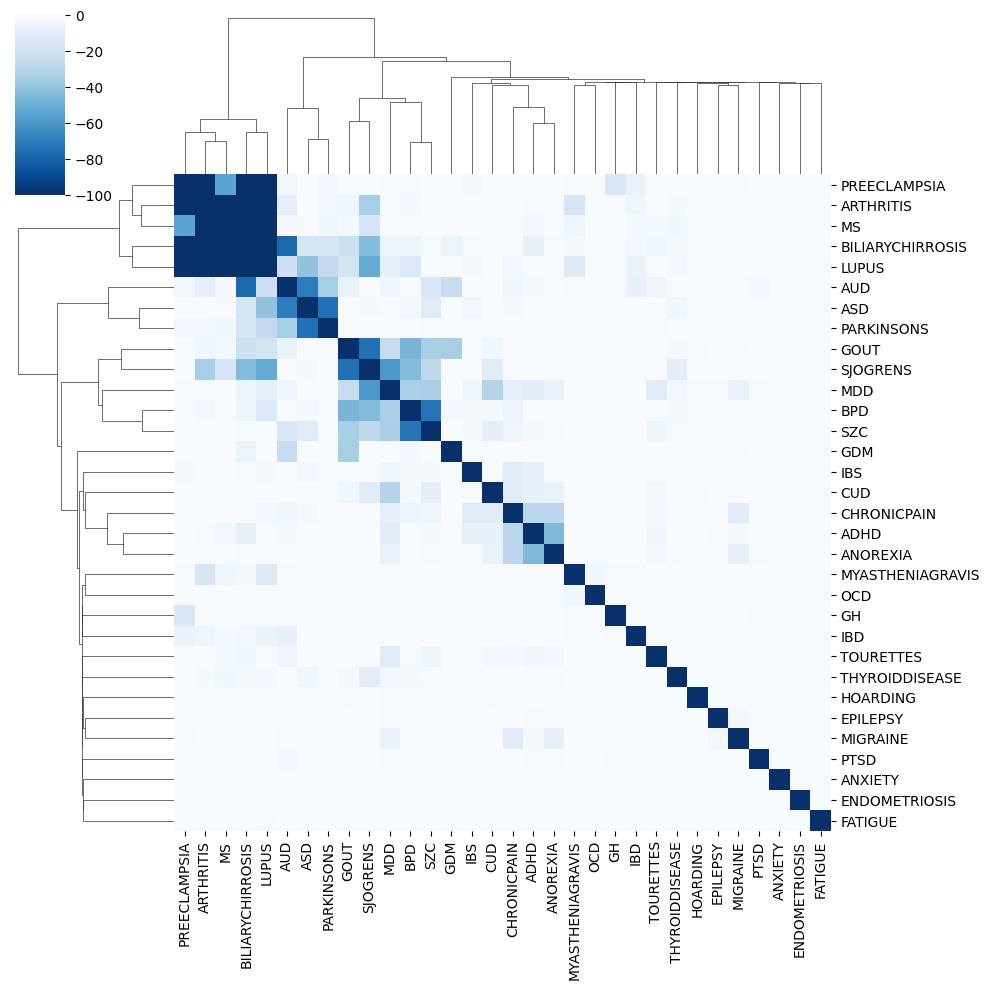

In [77]:
prob_genes_10K=hypergeometric_prob(disorder_matrix, disorders, 10000)
    
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(prob_genes_10K, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
prob_genes_10K = prob_genes_10K.mask(mask)

#Apply log transformation
prob_genes_10K_log = np.log10(prob_genes_10K+1e-100)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,25))
plt.title('M = 10000 with log transformation')
sns.heatmap(prob_genes_10K_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

prob_genes_10Kfull_matrix = np.tril(prob_genes_10K) + np.tril(prob_genes_10K, -1).T

prob_genes_10Kfull_df = pd.DataFrame(prob_genes_10Kfull_matrix, index=disorders, columns=disorders)
prob_genes_10Kfull_df = prob_genes_10Kfull_df.fillna(1e-100)
prob_genes_10Kfull_df_log = np.log10(prob_genes_10Kfull_df + 1e-100)

plt.figure(figsize=(25,25))
sns.clustermap(prob_genes_10Kfull_df_log,cmap=cmap_reversed)

plt.show()

    
    

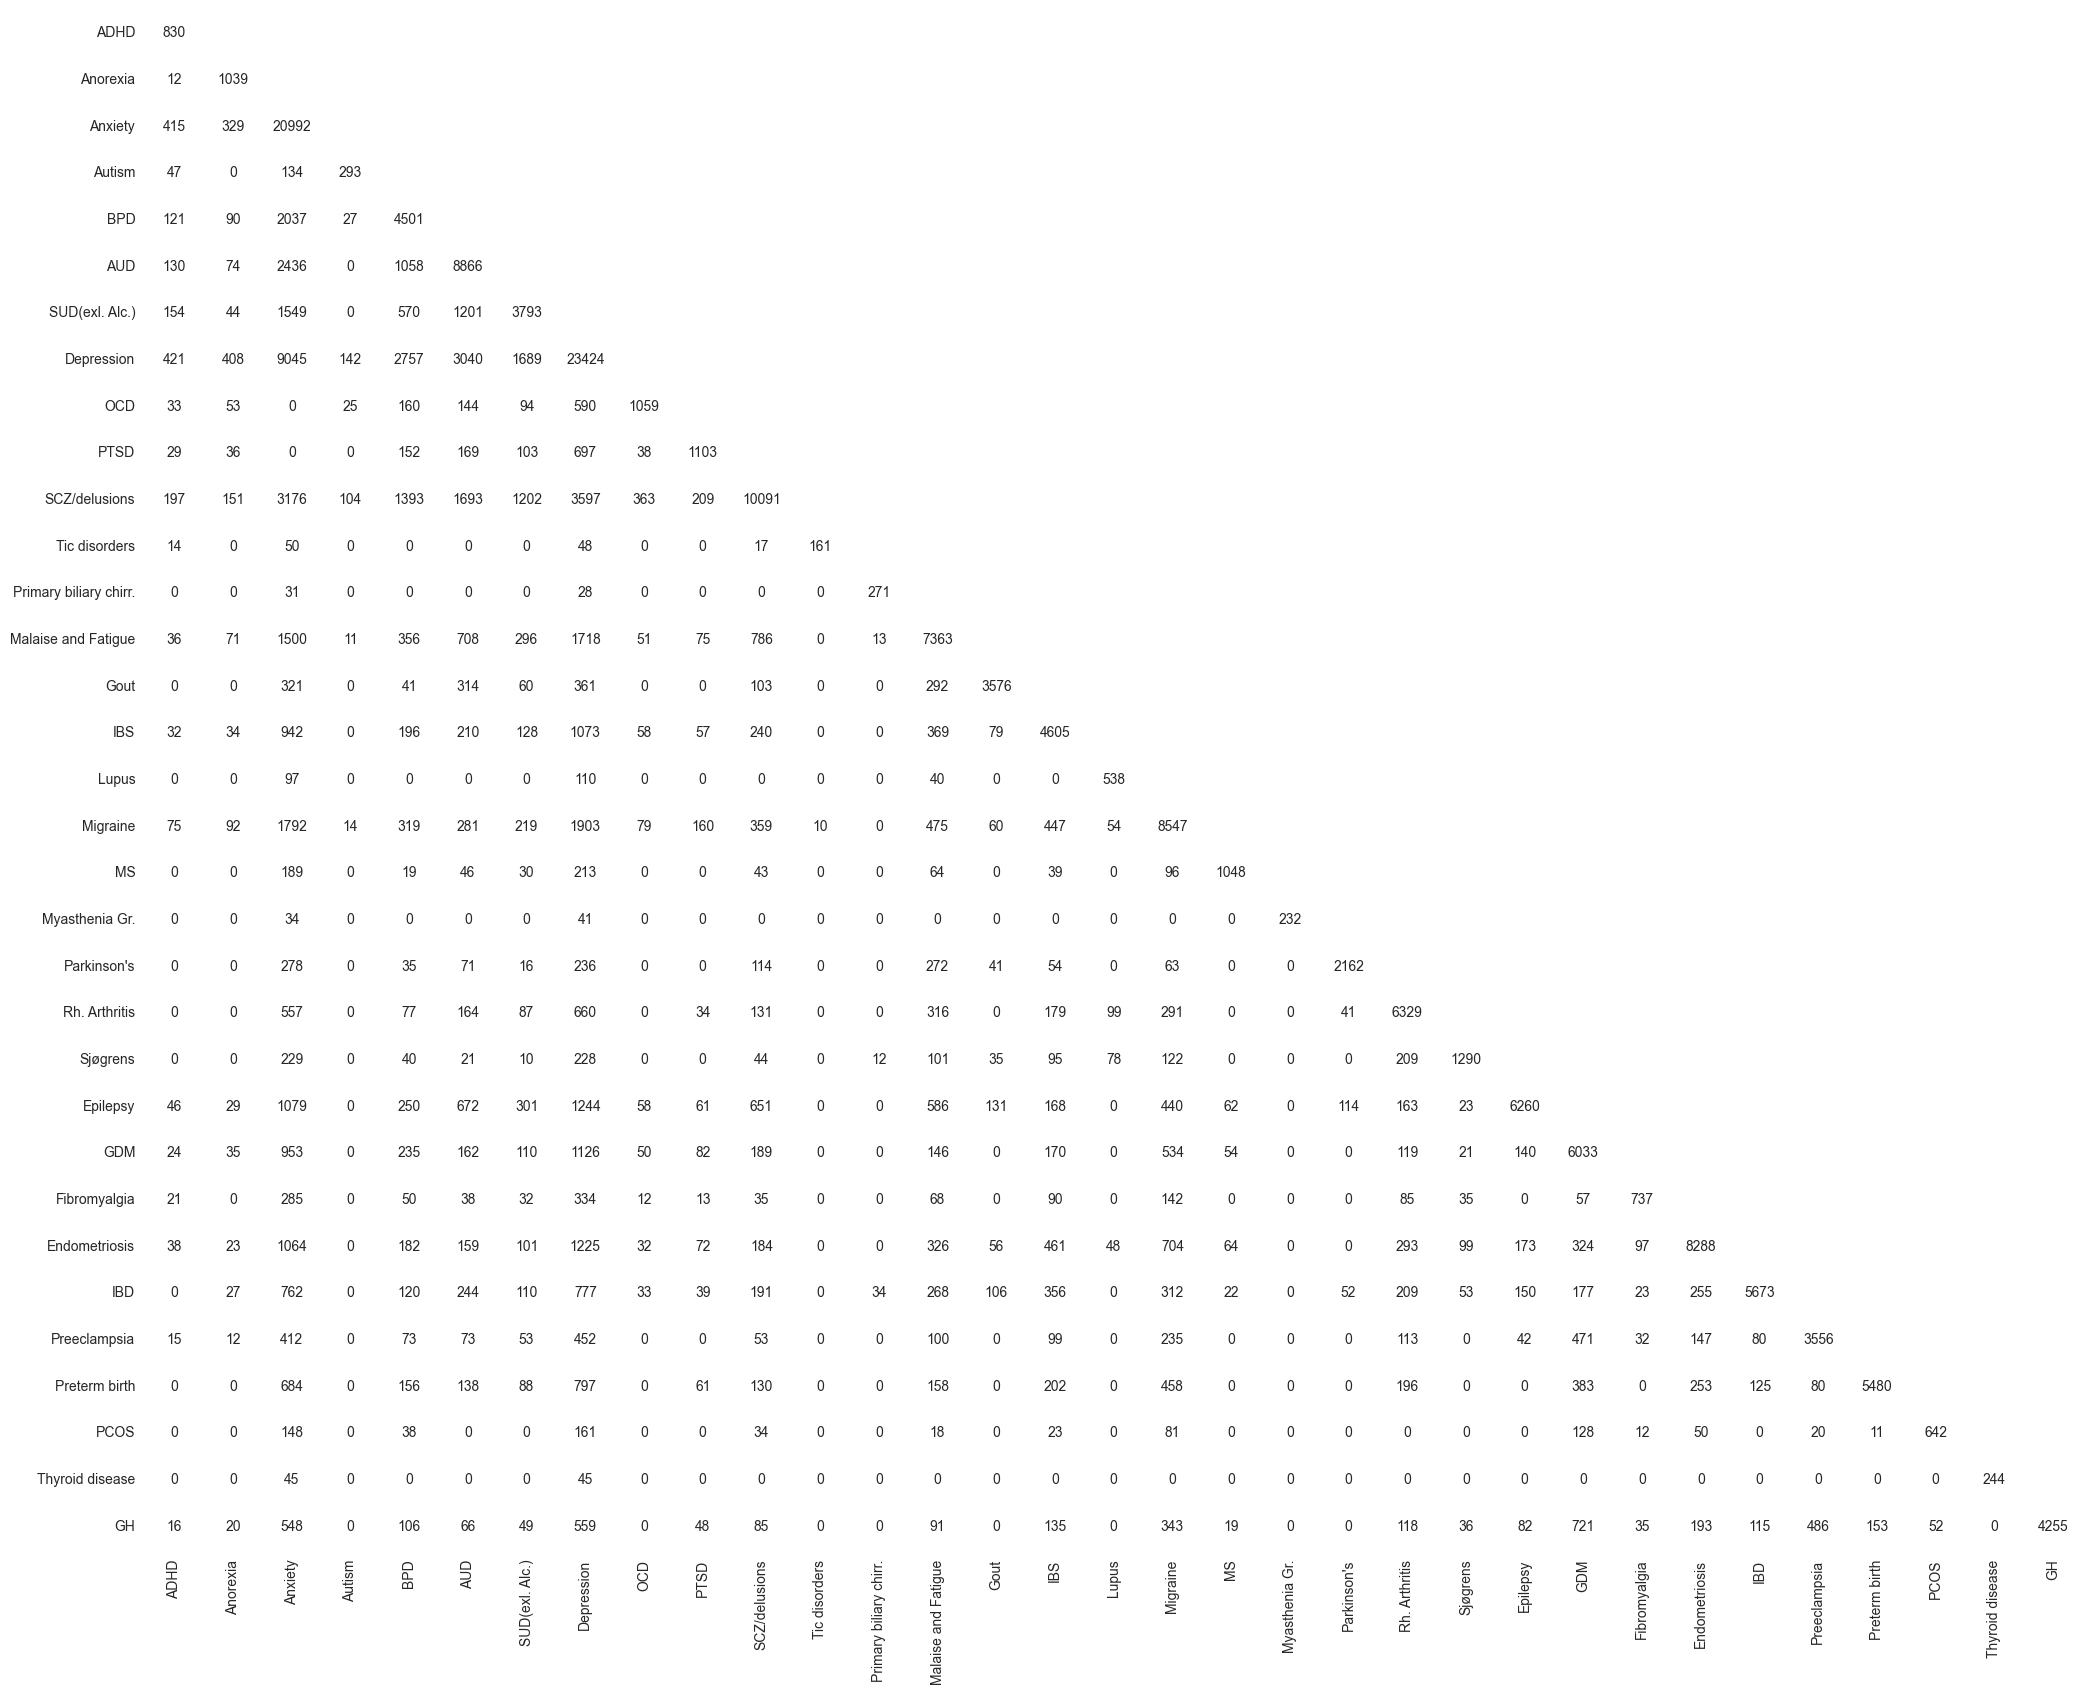

In [78]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)
disorder_list = finngen.index.values.tolist()
fin_matrix = finngen.to_numpy()
full_finngen_matrix2 = np.tril(finngen) + np.tril(finngen, -1).T
finngen2 = pd.DataFrame(full_finngen_matrix2, index=disorder_list, columns=disorder_list)

# Create a mask for the diagonal
diagonal_mask = np.eye(len(finngen2), dtype=bool)
mask = np.triu(np.ones_like(finngen2, dtype=bool), k=1)

plt.figure(figsize=(25,20))
with sns.axes_style('white'):
    sns.heatmap(finngen2,cmap=ListedColormap(['white']), annot=True, fmt='.0f', mask=mask, cbar=False)
    plt.show()

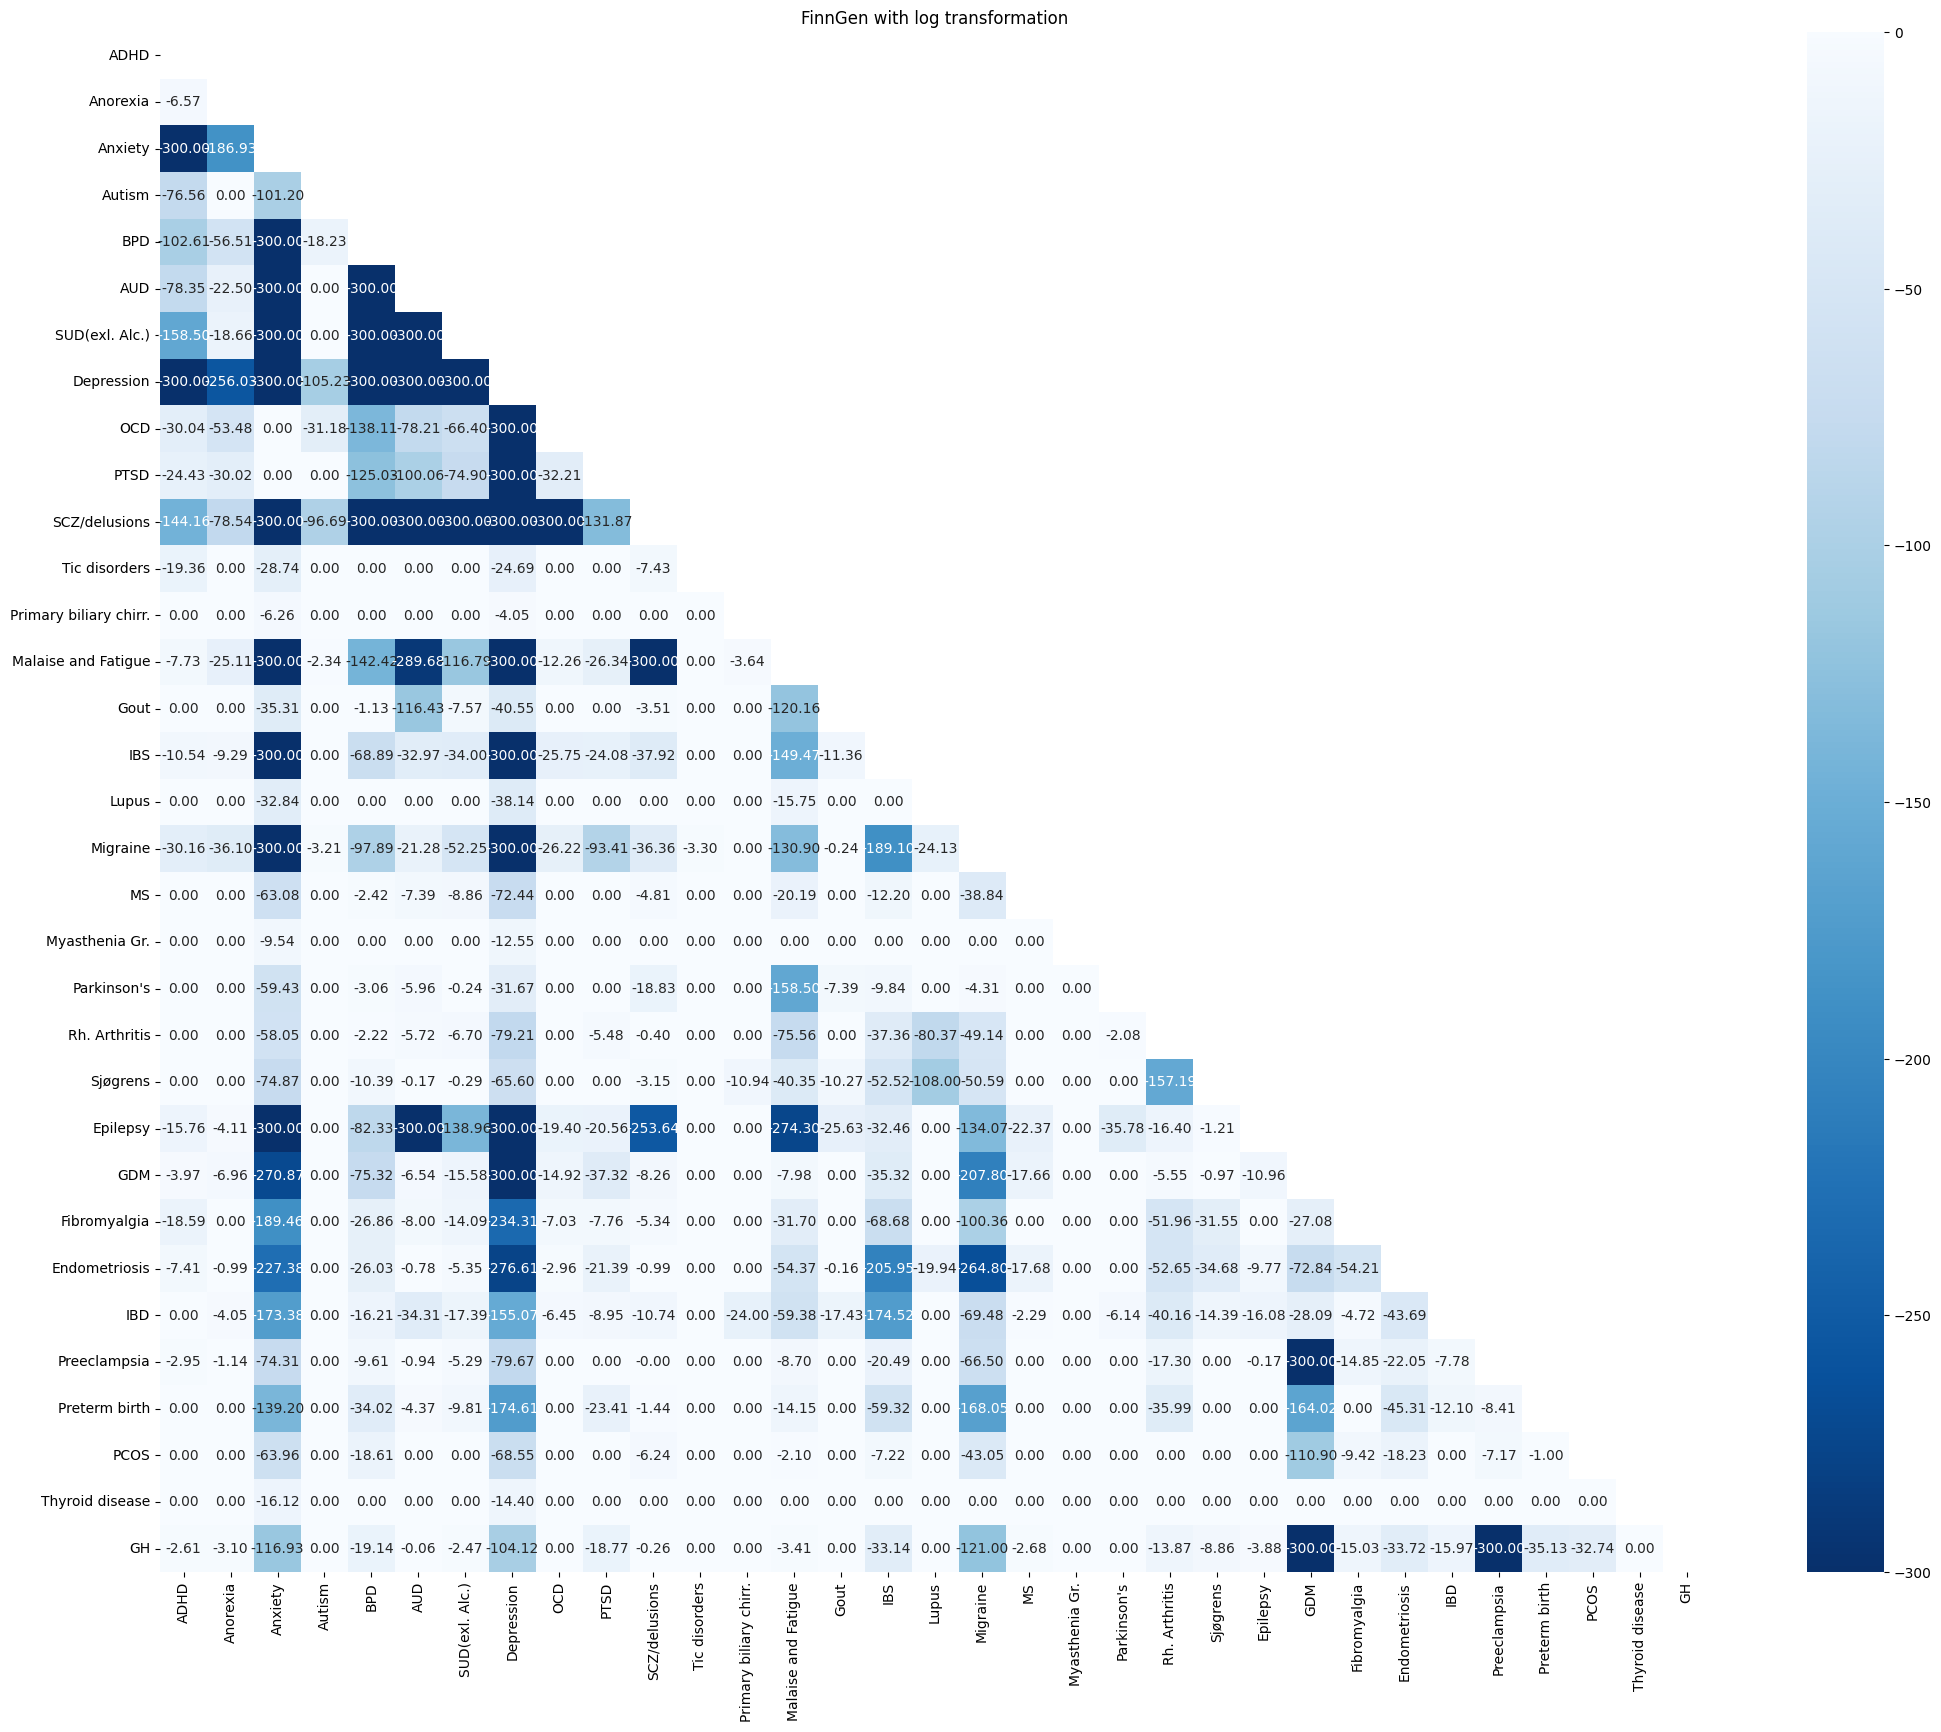

<Figure size 2000x1500 with 0 Axes>

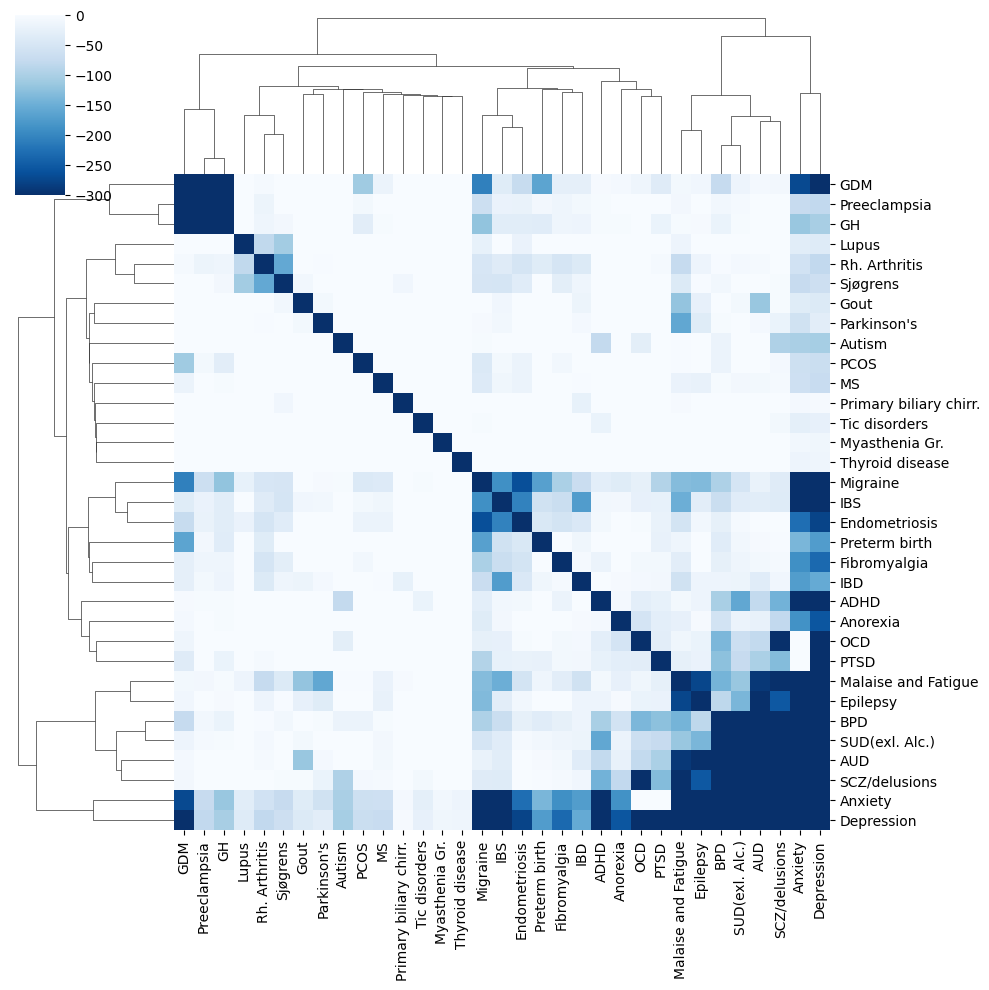

In [34]:
finngen_p = hypergeometric_prob(fin_matrix,disorder_list, 500000)

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(finngen_p, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
finngen_p = finngen_p.mask(mask)

#Apply log transformation
finngen_log = np.log10(finngen_p+1e-300)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,20))
plt.title('FinnGen with log transformation')
sns.heatmap(finngen_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

full_finngen_matrix = np.tril(finngen_p) + np.tril(finngen_p, -1).T
full_finngen_df = pd.DataFrame(full_finngen_matrix, index=disorder_list, columns=disorder_list)
full_finngen_df = full_finngen_df.fillna(1e-300)
full_finngen_log = np.log10(full_finngen_df+1e-300)
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed)
plt.show()


<Figure size 2000x1500 with 0 Axes>

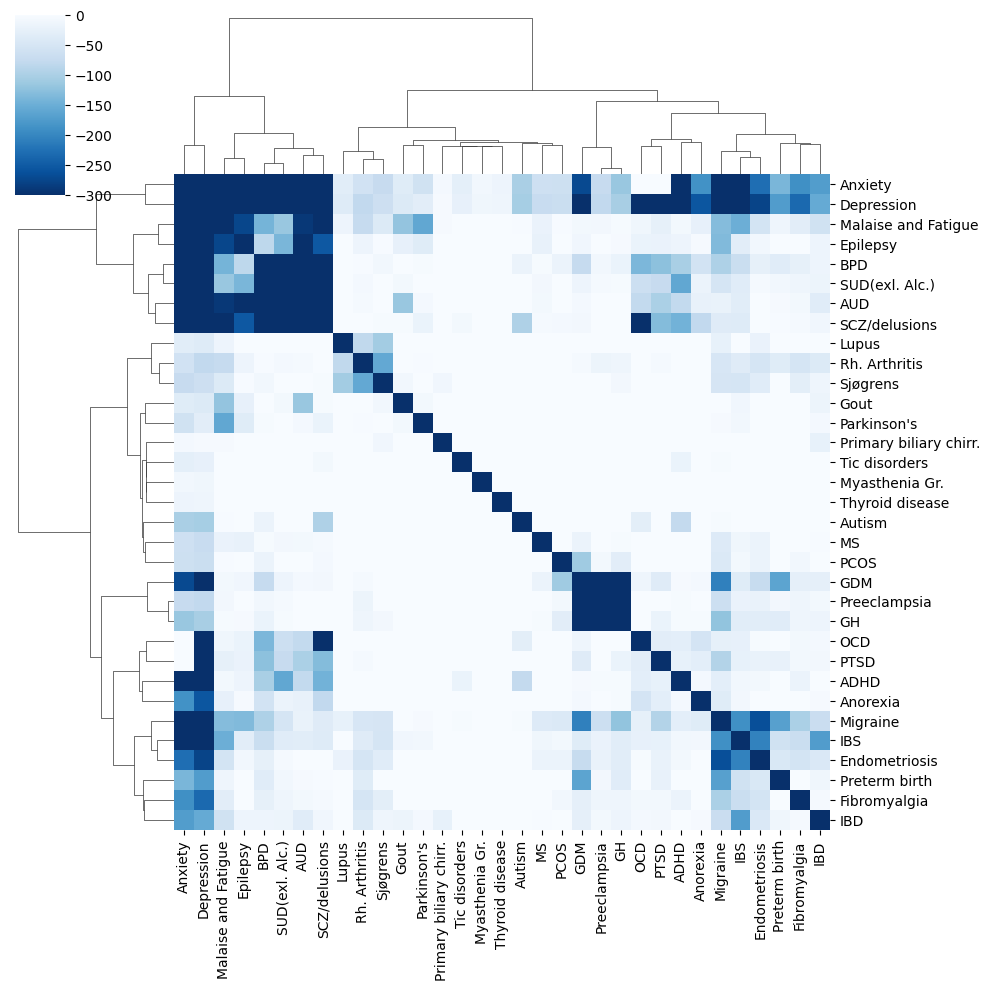

In [29]:
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed, method='ward')
plt.show()

<Figure size 2000x1500 with 0 Axes>

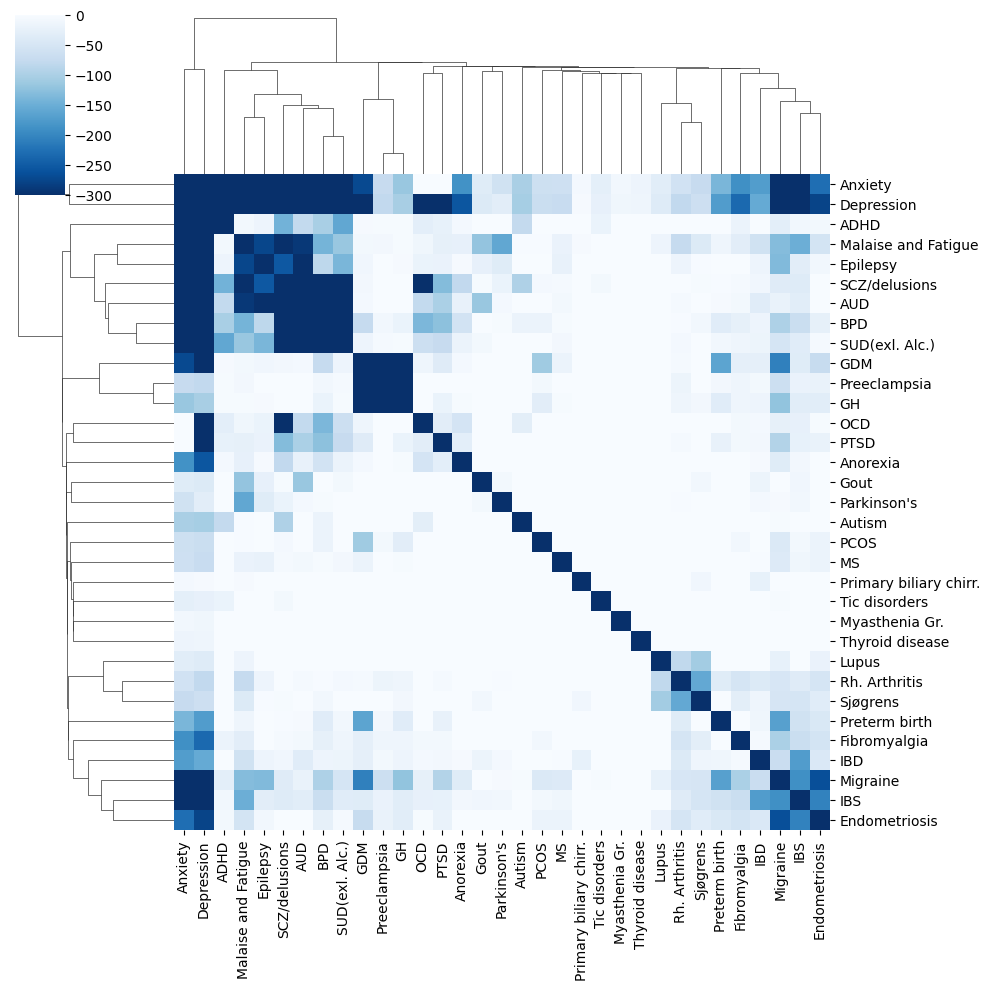

In [30]:
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed, method='single')
plt.show()

<Figure size 2000x1500 with 0 Axes>

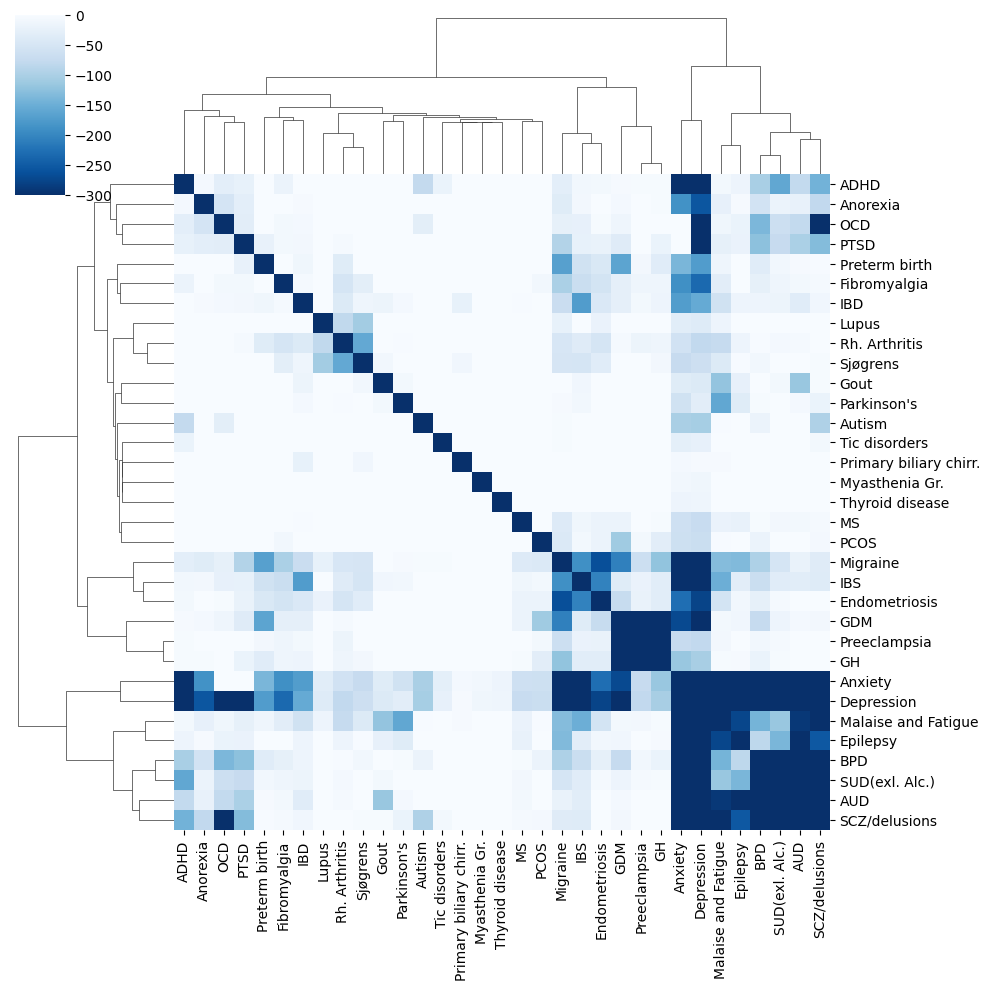

In [31]:
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed, method='complete')
plt.show()